In [1]:
import pandas as pd

def load_dataset():
    ds = pd.read_csv('resources/hour.csv')
    ds['dteday'] = pd.to_datetime(ds['dteday'])
    return ds
    
def one_hot_encoding(df, field):
    one_hot_encoded = pd.get_dummies(df[field])
    return  pd.concat([df.drop(field, axis=1), one_hot_encoded], axis=1)
    
def preprocess_dataset(df):

    df_reduced = df[['dteday', 'cnt', 'season','yr', 'mnth','hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
    df_reduced = one_hot_encoding(df_reduced, 'season')
    df_reduced = one_hot_encoding(df_reduced, 'mnth')
    df_reduced = one_hot_encoding(df_reduced, 'hr')
    df_reduced = one_hot_encoding(df_reduced, 'weekday')
    df_reduced = one_hot_encoding(df_reduced, 'weathersit')
    
    return df_reduced

dataset = load_dataset()
dataset = preprocess_dataset(dataset)

In [2]:
from datetime import datetime

def filter_by_date(ds, start_date, end_date):
    
    start_date_parsed = datetime.strptime(start_date, "%Y-%m-%d") 
    start_end_parsed = datetime.strptime(end_date, "%Y-%m-%d")
    
    return ds[(ds['dteday'] >= start_date_parsed) & (ds['dteday'] <= start_end_parsed)]

train = filter_by_date(dataset, '2011-01-01', '2012-10-31')
dev = filter_by_date(dataset, '2012-11-01', '2012-11-30')
val = filter_by_date(dataset, '2012-12-01', '2012-12-31')

In [3]:
import numpy as np

def reshape_dataset(ds):

    Y = ds['cnt'].values

    ds_values = ds.drop(['dteday', 'cnt'], axis=1).values
    X = np.reshape(ds_values, (ds_values.shape[0], 1, ds_values.shape[1]))
    
    return X, Y

X_train, Y_train = reshape_dataset(train)
X_dev, Y_dev = reshape_dataset(dev)
X_val, Y_val = reshape_dataset(val)

In [4]:
%matplotlib inline

import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

Using TensorFlow backend.


In [5]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout

def get_model():

    input = Input(shape=(1, 58))
    x = LSTM(200)(input)
    x = Dropout(.5)(x)
    activation = Dense(1, activation='linear')(x)
    model = Model(inputs=input, outputs=activation)
    
    optimizer = keras.optimizers.Adam(lr=0.01,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=None,
                                      decay=0.001,
                                      amsgrad=False)

    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    model.summary()

    return model

get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 58)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               207200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 207,401
Trainable params: 207,401
Non-trainable params: 0
_________________________________________________________________


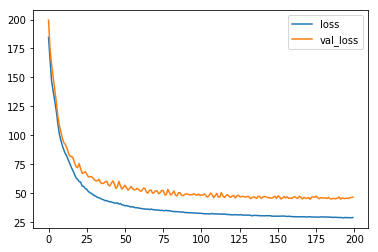

In [10]:
def train_model(model, X_train, Y_train, validation, callbacks):

    model.fit(X_train, Y_train, epochs=200, batch_size=1024, validation_data=validation, callbacks=callbacks, shuffle=False)
    return model
  
model = train_model(get_model(), X_train, Y_train, (X_dev, Y_dev), [plot_losses])

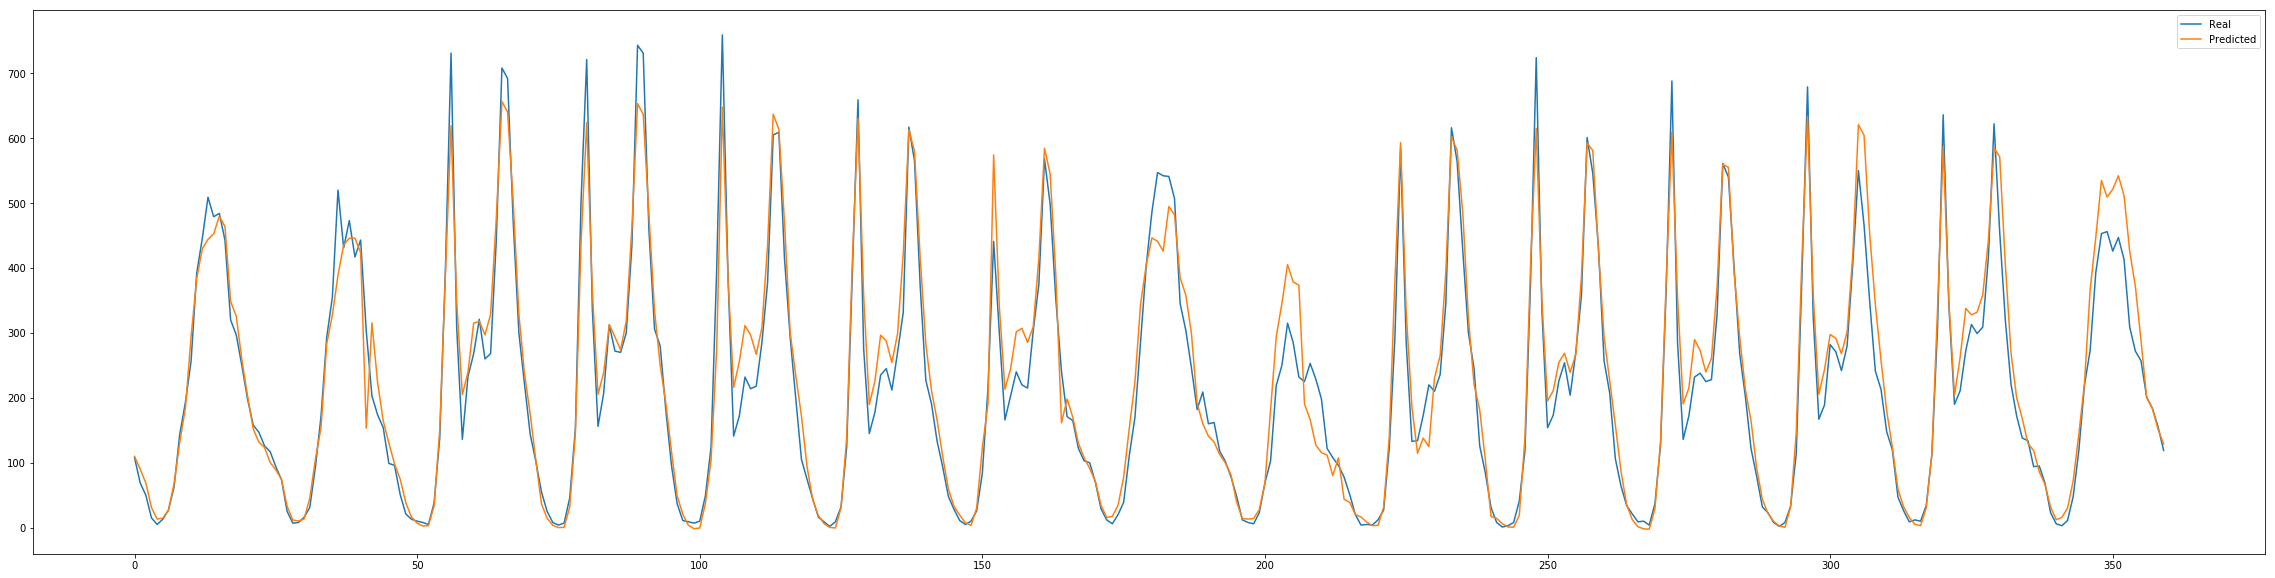

31.452976872523625

In [11]:
from sklearn.metrics import mean_absolute_error

def show_predict(model, X, Y):
    
    Y_predict = model.predict(X)
    
    plt.figure(figsize=(40,10))
    plt.plot(list(range(len(Y))), Y, label="Real")
    plt.plot(list(range(len(Y_predict))), Y_predict, label="Predicted")
    plt.legend()
    plt.show()

    return mean_absolute_error(Y, Y_predict)

show_predict(model, X_val[:360], Y_val[:360])

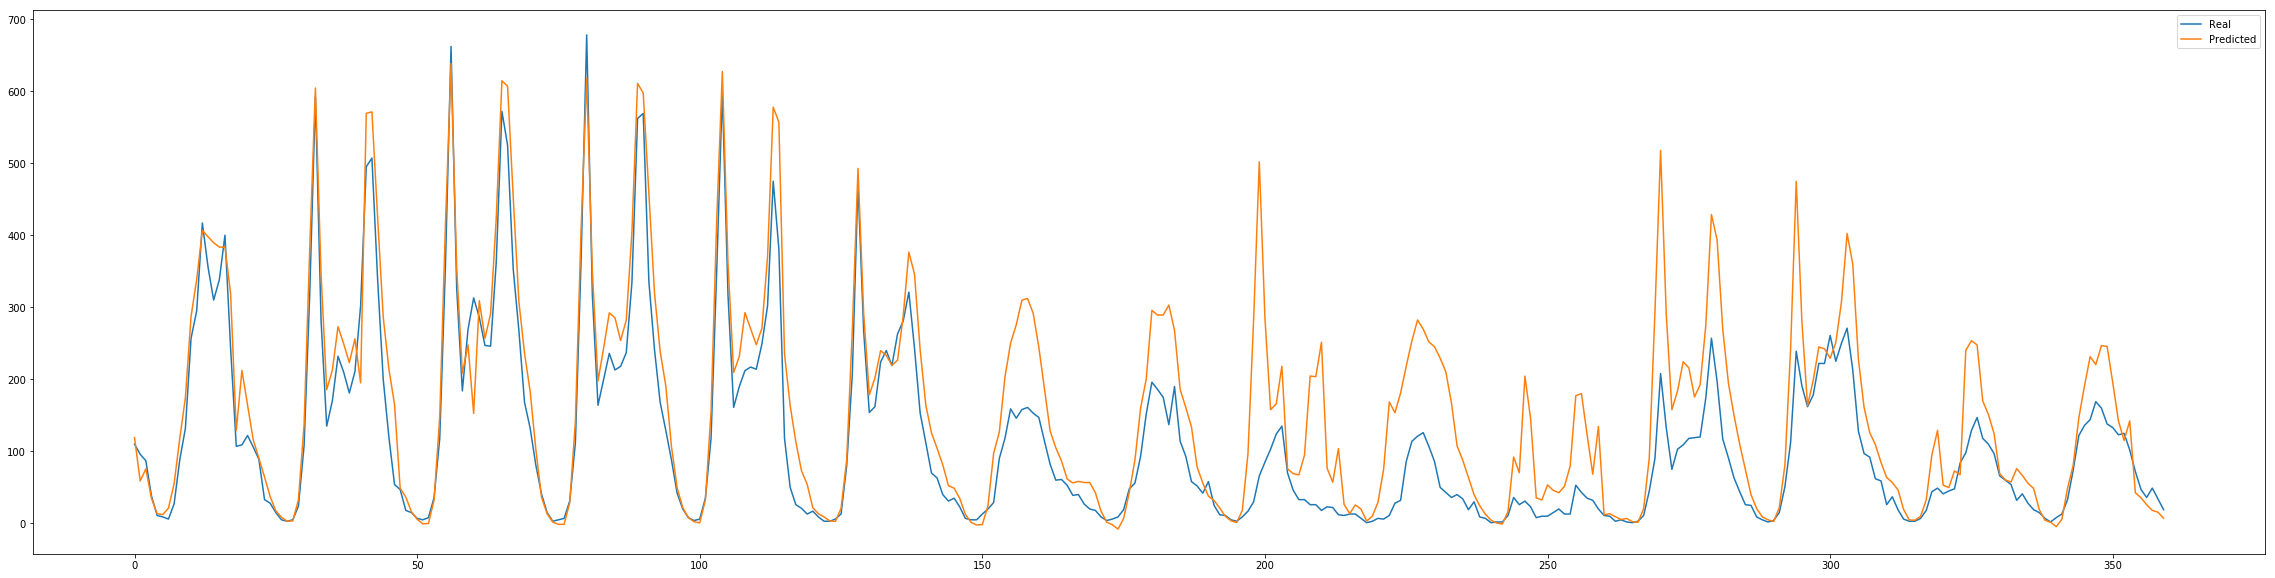

51.37851409514745

In [12]:
show_predict(model, X_val[360:720], Y_val[360:720])